In [1]:
using ITensors
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
N=40;

function helixstate(λ;flip=false)
    Q=2*pi/λ
    sites = siteinds("Qubit", N; conserve_qns=false)
    psi = MPS(N)

    states = [state(sites[j], "X+") for j in 1:N]
    [states[j][2]=cos((j)*Q/2+0.25*pi*flip) for j in 1:N]
    [states[j][1]=-sin((j)*Q/2+0.25*pi*flip) for j in 1:N]

    links = [Index(1; tags="Link,l=$n") for n in 1:N]


    psi[1] = ITensor(Float64, sites[1], links[1])
    psi[1] += states[1] * state(links[1], 1)
    
    for n in 2:(N - 1)
        psi[n] = ITensor(Float64, dag(links[n - 1]), sites[n], links[n])
        psi[n] += state(dag(links[n - 1]), 1) * states[n] * state(links[n], 1)
    end

    psi[N] = ITensor(Float64, dag(links[N - 1]), sites[N])
    psi[N] += state(dag(links[N - 1]), 1) * states[N]
    
    return(sites,psi)
end

function XXZquench(λ,ttotal,τ; Δ=0,flip=false)
    
    sites,psi=helixstate(λ;flip=flip)

    cutoff = 1E-9
    gates = ITensor[]

    for j in 1:(N - 1)
      s1 = sites[j]
      s2 = sites[j + 1]
      hj =
        Δ*op("Sz", s1) * op("Sz", s2) +
        1 / 2 * op("S+", s1) * op("S-", s2) +
        1 / 2 * op("S-", s1) * op("S+", s2)
      Gj = exp(-im * τ / 2 * hj)
      push!(gates, Gj)
    end
# Include gates in reverse order too
# (N,N-1),(N-1,N-2),...
    append!(gates, reverse(gates))

    Szlist=[]
    for t in 0.0:τ:ttotal
      Sz = expect(psi, "Sz")
      print(isinteger(t) ? "$t" : "   ")
      push!(Szlist,Sz)
      t≈ttotal && break
      psi = apply(gates, psi; cutoff, maxdim=800)
      normalize!(psi)
    end
    println("   ")
    return(Szlist)

end

function XXZquench_ensemble(λ,ttotal,τ; Δ=0)
    Szlist1=XXZquench(λ,ttotal,τ;Δ=Δ,flip=true);
    Szlist2=XXZquench(λ,ttotal,τ;Δ=Δ,flip=false);
    Szlist_ensemble=[Szlist1,Szlist2]
    t_norm=[0:τ:ttotal;]./λ
    return t_norm,Szlist_ensemble,λ
end

XXZquench_ensemble (generic function with 1 method)

In [9]:
#tnorm2,Szens2,λ2=XXZquench_ensemble(10 ,10 ,0.1; Δ=0);

#tnorm1,Szens1,λ1=XXZquench_ensemble(8 ,8 ,0.1; Δ=0);

#tnorm3,Szens3,λ3=XXZquench_ensemble(8 ,7 ,0.1; Δ=0);

tnorm4,Szens4,λ4=XXZquench_ensemble(10.4, 8,0.05; Δ=-1.5);

0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                                         5.0                                                         6.0                                                         7.0                                                         8.0   
0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                                         5.0                                                         6.0                                                         7.0                                                         8.0   


┌ Info: Saved animation to C:\Users\lvjia\MPS\tmp.gif
└ @ Plots C:\Users\lvjia\.julia\packages\Plots\M4dfL\src\animation.jl:156


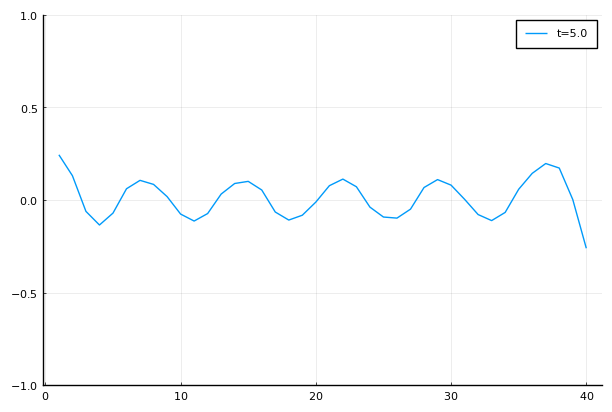

Plots.AnimatedGif("C:\\Users\\lvjia\\MPS\\tmp.gif")
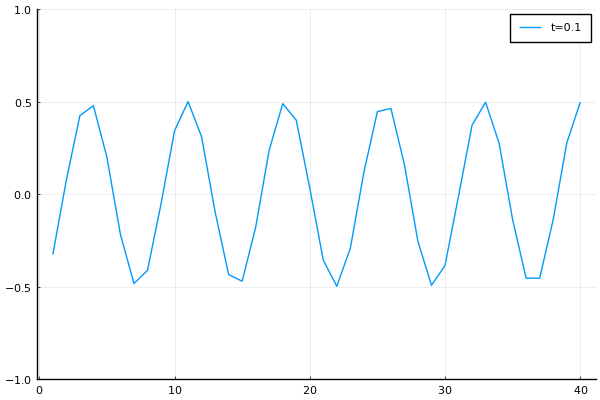

In [49]:

anim = @animate for i = 1:50
    temp_label=
    plot(Szens3[2][i], label=string("t=",i/10))
    plot!(ylim=(-1,1))
end

gif(anim,  fps = 10)


In [13]:
using DelimitedFiles
writedlm( "test.csv", Szlist, ',')

## The contrast

  The initial state prepared in the simulation is $|\psi(Q)\rangle=\prod_i|\varphi\rangle_i$, where
  $$
  |\varphi\rangle_i=\cos \left(Q z_i / 2\right)|\downarrow\rangle_i-\sin \left(Q z_i / 2\right)|\uparrow\rangle_i
  $$
  
  The contrast of an arbitrary time is:
  
  $$
  c(t)=\frac{4 a}{L} \sum_i\left\langle S_i^z(t)\right\rangle \cos \left(Q z_i+\theta\right)
  $$

In [7]:
function contrast_plot(Szens,λ)
    timestep=size(Szens[1])[1];
    contrast1=zeros(timestep);
    contrast2=zeros(timestep);
    Szlist1=Szens[1]
    Szlist2=Szens[2]
    for ti in 1:timestep
        contrast1[ti]=sum(Szlist1[ti][i]*cos(2*pi/λ*i+0.5pi) for i in 1:length(Szlist1[1]));
        contrast2[ti]=sum(Szlist2[ti][i]*cos(2*pi/λ*i) for i in 1:length(Szlist2[1]));
    end
    contrast1=contrast1./sum(Szlist1[1][i]*cos(2*pi/λ*i+0.5pi) for i in 1:length(Szlist1[1]));
    contrast2=contrast2./sum(Szlist2[1][i]*cos(2*pi/λ*i) for i in 1:length(Szlist2[1]));
    return(contrast1,contrast2) 
end


contrast_plot (generic function with 1 method)

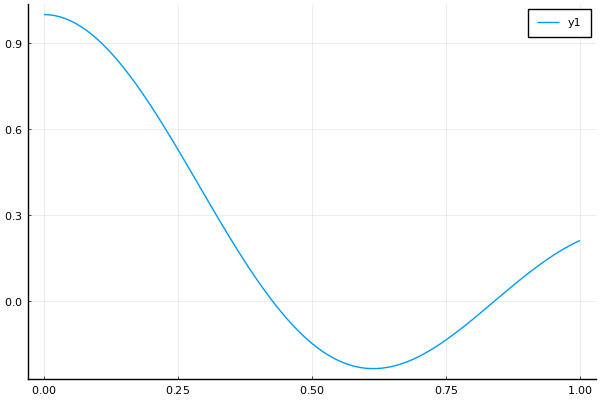

In [25]:
plot(tnorm2,(contrast_plot(Szens2,λ2)[1]+contrast_plot(Szens2,λ2)[2])/2)
#plot!(contrast_plot(Szens)[2])


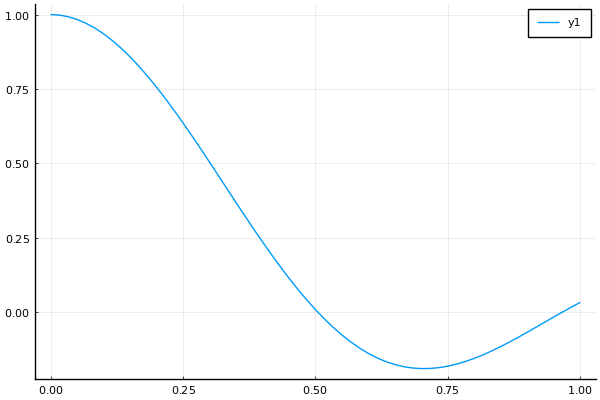

In [44]:
plot(tnorm1,(contrast_plot(Szens1,λ1)[1]+contrast_plot(Szens1,λ1)[2])/2)


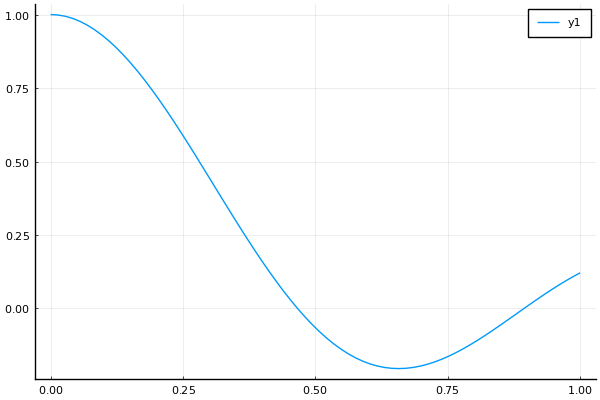

In [50]:
plot(tnorm3,(contrast_plot(Szens3,λ3)[1]+contrast_plot(Szens3,λ3)[2])/2)


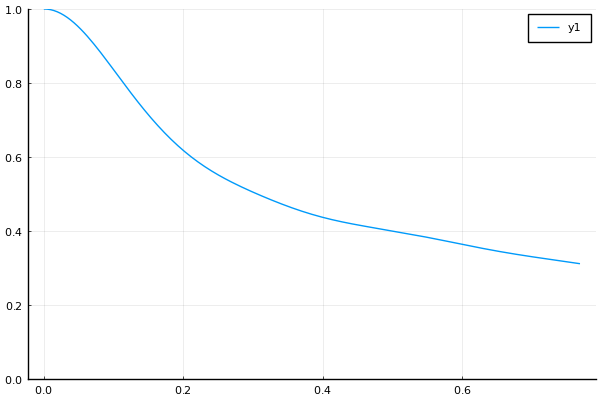

In [11]:
plot(tnorm4,(contrast_plot(Szens4,λ4)[1]+contrast_plot(Szens4,λ4)[2])/2,ylim=(0,1))


In [4]:
function decay_time(λ,ttotal,τ, Δ)
    tnorm0 ,Szens0,λ0=XXZquench_ensemble(λ,ttotal,τ; Δ=Δ)
    contrast1 ,contrast2=contrast_plot(Szens0,λ0)
    contrast=(contrast1+contrast2)/2
    Tidecay=findmin(abs.(contrast .-0.6))[2];
    println(Tidecay)
    Tdecay=-Tidecay*τ/log(0.6)
end

decay_time (generic function with 1 method)

In [83]:
decay_time(10,7,0.1,0)

0.0                           1.0                           2.0                           3.0                           4.0                           5.0                           6.0                           7.0   
0.0                           1.0                           2.0                           3.0                           4.0                           5.0                           6.0                           7.0   
24


0.4698276453530923

In [9]:
λlist=[6.5:0.5:15;]

decaylist=decay_time.(λlist,4.5,0.05,0)

0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                 
0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                 
34
0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                 
0.0                                                         1.0                                                         2.0                                           

18-element Vector{Float64}:
 3.32794582125107
 3.5237073401481918
 3.7194688590453135
 3.8173496184938744
 4.013111137390997
 4.208872656288118
 4.404634175185239
 4.502514934633801
 4.698276453530923
 4.894037972428044
 5.089799491325166
 5.285561010222287
 5.481322529119409
 5.677084048016532
 5.872845566913653
 6.068607085810775
 6.264368604707896
 6.460130123605018

In [7]:
λlist=[11.5]
decaylist=decay_time.(λlist,11.5,0.1,1)

0.0                           1.0                           2.0                           3.0                           4.0                           5.0                           6.0                           7.0                           8.0                           9.0                           10.0                           11.0                  
0.0                           1.0                           2.0                           3.0                           4.0                           5.0                           6.0                           7.0                           8.0                           9.0                           10.0                           11.0                  
116


1-element Vector{Float64}:
 22.708336192066128

In [113]:
λlist=[6.3,8,9.4]
decaylist=decay_time.(λlist,9,0.05,1)

0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                                         5.0                                                         6.0                                                         7.0                                                         8.0                                                         9.0   
0.0                                                         1.0                                                         2.0                                                         3.0                                                         4.0                                                         5.0                                                         6.0                                                         7.0                              

3-element Vector{Float64}:
  7.0474146802963835
 11.941452652724427
 16.737609865703913

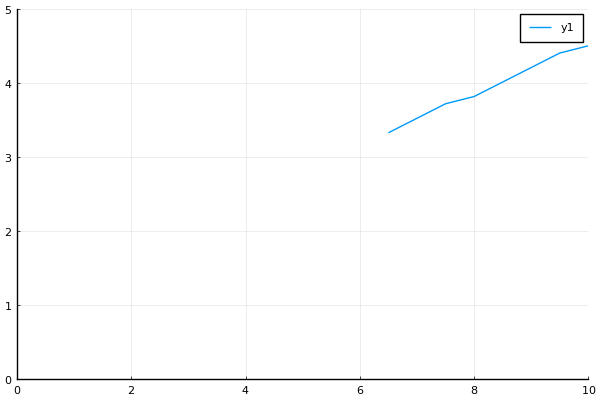

In [10]:
plot(λlist,decaylist,xlim=(0,10),ylim=(0,5))

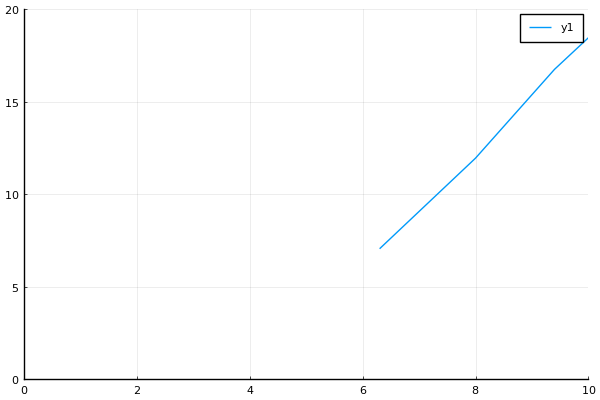

In [4]:
using CurveFit

λlist2=[6.3,8,9.4,11.5]
decaylist2=[7.0474146802963835,11.941452652724427,16.737609865703913,22.708]
plot(λlist2,decaylist2,xlim=(0,10),ylim=(0,20))
#power_fit(λlist2,decaylist2)

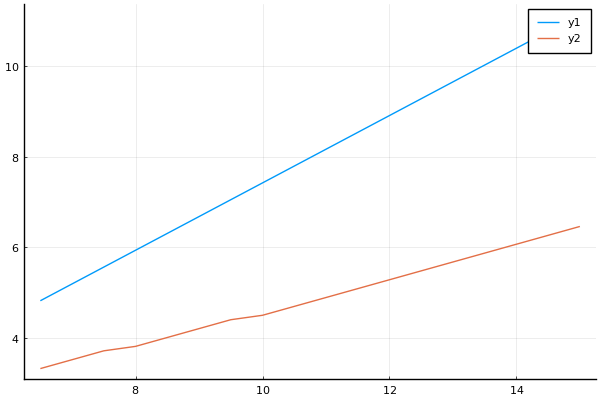

In [19]:
using CurveFit
power_fit(λlist,decaylist)

plot(λlist,0.742 .*λlist.^1)
plot!(λlist,decaylist)